In [3]:
import numpy
import pymongo
import scipy
import torch
import tqdm
import transformers

# To do - 

0. Scrape dataset 
1. confirm gpu usage
2. fine-tune MatBERT
3. access checkpoint fine-tuned to model encoder
4. create VAE set up using encoder-decoder set up - Consider Loss function as: (g(f(x)) - x) (reconstruction) + (y-y_hat) (property loss): to create latent space representation
5. sample from latent space and create valid pool of encoded_reps using descrimator 
6. figure out bayesian optimazation technique : similarity comparison etc.

In [8]:
from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

# Data

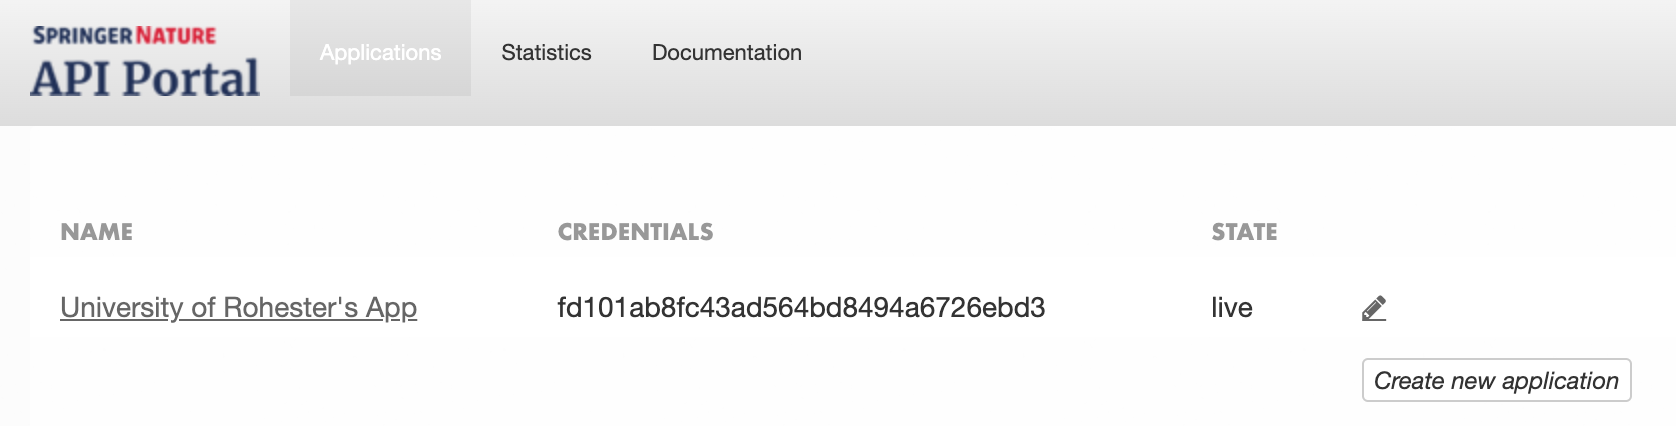

In [31]:
from IPython.display import Image
# Image(filename='Elesiver_personal_api.png')
Image(filename='springer_nature_api.png')

In [6]:
# Convert data into hugging face library, load data, Pre-processing data if needed 
# Science direct & Elesiver API for allowed scraping : doi, paragraph, synthesis type: hydrothermal etc.

# Paragraph classifer for identifying hydrothermal synthesis methods - https://github.com/CederGroupHub/MatBERT-synthesis-classifier/tree/0efad16dea5fe3028cde44e06f7cc6b57b599869 
data=load_dataset("**") # make it a list of paragraphs

# MatBERT - Material Bidirectional Encoder Representations Transformers 

# Tokenize data

QUESTIONS: 
1. Can/Should I add more tokens to token dict/lib? does the tokenizer do this automatically?

In [9]:
from transformers import BertForMaskedLM, BertTokenizerFast, pipeline
from pprint import pprint

#Call appropriate tokenizer:
tokenizer = BertTokenizerFast.from_pretrained('/gpfs/fs1/home/smichtav/ML_book/Transformer/matbert-base-cased', do_lower_case=False, truncate=True)
# tokenizer_bert = BertTokenizerFast.from_pretrained('bert-base-cased', do_lower_case=False, tuncate=True)

# tokenize data:
def tokenizer_func(feat): 
    
    tokenized_dat = []
    for i in feat:
        tokenized_dat.append(tokenizer(feat))
    
    return tokenized_dat

tokenized_dat=tokenizer_func('Tetraethyl orthosilicate (TEOS, 12.50 g) was first mixed with tetrapropylammonium hydroxide (TPAOH, 25 wt% in water, Acros Organics, 12.00 g) and stirred at 80 °C for 24 h.')
matbert_tokens=tokenizer.tokenize('Tetraethyl orthosilicate (TEOS, 12.50 g) was first mixed with tetrapropylammonium hydroxide (TPAOH, 25 wt% in water, Acros Organics, 12.00 g) and stirred at 80 °C for 24 h.')
# bert_tokens=tokenizer_bert.tokenize('Tetraethyl orthosilicate (TEOS, 12.50 g) was first mixed with tetrapropylammonium hydroxide (TPAOH, 25 wt% in water, Acros Organics, 12.00 g) and stirred at 80 °C for 24 h.')


# visualize tokenized data:
print("matbert:",matbert_tokens)
#print("bert",bert_tokens)

#consider when tokenizer uses special tokens
# def tokenize_func(feat):
#       tokenized_dat= tokenizer(feat["tokens"], is_split_into_words=True,truncation=True) # tuncate to models maximum input length
  
#       labels= []
#       for i, label in enumerate(feat[f"ner_tags"]): # found this on hugging face
#         word_ids= tokenized_dat.word_ids(batch_index=i) # map tokens to word id
#         label_ids= []
#         for word_idx in word_ids: 
#             if word_idx is None:
#                 label_ids.append(-100) #set symbols/special tokens to -100
#             elif word_idx != previous_word_idx:
#                 label_ids.append(label[word_idx])
#             else:
#                 label_ids.append(-100)
#                 previous_word_idx = word_idx
#         labels.append(label_ids)
  
#       tokenized_dat["labels"]=labels
#     return tokenized_dat


# work on all data simultaneously - add tokenized data tokens to token dictionary?
#tokenized_dat = data.map(tokenize_func, batched=True) 

matbert: ['Tetra', '##ethyl', 'ortho', '##sil', '##icate', '(', 'TEOS', ',', '12', '.', '50', 'g', ')', 'was', 'first', 'mixed', 'with', 'tetrap', '##ropyl', '##ammonium', 'hydroxide', '(', 'TPA', '##OH', ',', '25', 'wt', '%', 'in', 'water', ',', 'Acros', 'Organic', '##s', ',', '12', '.', '00', 'g', ')', 'and', 'stirred', 'at', '80', '°C', 'for', '24', 'h', '.']


# Fine-Tuning MatBERT

QUESTIONS:
1. should I fine-tune on multiple tasks? (eg. text generation, mask-fill)

In [11]:
from transformers import TrainingArguments,Trainer # can use AutoModelFor** for chaning task head -- [MASK]

model = BertForMaskedLM.from_pretrained('/gpfs/fs1/home/smichtav/ML_book/Transformer/matbert-base-cased')
unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer) 
pprint(unmasker("Tetraethyl orthosilicate (TEOS, 12.0 g) was first mixed with tetrapropylammonium [MASK] (TPAOH, 25 wt% in water, [MASK] Organics, 12.00 g) and [MASK] at 80°C for 24 h."))

# train_args= TrainingArguments(output_dir="gpfs/fs1/home/smichtav/ML_book/Transformer/output_dir",  # only imparative to specify output directory
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=5,
#     weight_decay=0.01,
# )

# model_train= Trainer(
#     model=model,
#     args=train_args,
#     train_dataset=tokenized_dat["train"],
#     eval_dataset=tokenized_dat["validation"],
#     tokenizer=tokenizer,
#     data_collator=collator)

# model_train.train() # check output folder for more info

#export model checkpoint?



[[{'score': 0.9984873533248901,
   'sequence': '[CLS] Tetraethyl orthosilicate ( TEOS, 12. 0 g ) was first '
               'mixed with tetrapropylammonium hydroxide ( TPAOH, 25 wt % in '
               'water, [MASK] Organics, 12. 00 g ) and [MASK] at 80°C for 24 '
               'h. [SEP]',
   'token': 7681,
   'token_str': 'hydroxide'},
  {'score': 0.0007294830866158009,
   'sequence': '[CLS] Tetraethyl orthosilicate ( TEOS, 12. 0 g ) was first '
               'mixed with tetrapropylammonium alcohol ( TPAOH, 25 wt % in '
               'water, [MASK] Organics, 12. 00 g ) and [MASK] at 80°C for 24 '
               'h. [SEP]',
   'token': 6097,
   'token_str': 'alcohol'},
  {'score': 0.00019115483155474067,
   'sequence': '[CLS] Tetraethyl orthosilicate ( TEOS, 12. 0 g ) was first '
               'mixed with tetrapropylammonium hydroxides ( TPAOH, 25 wt % in '
               'water, [MASK] Organics, 12. 00 g ) and [MASK] at 80°C for 24 '
               'h. [SEP]',
   'token': 18372,

INTERESTING OUTPUT: CLOSE TO PREDICTING TEMP.

In [ ]:
# Learn transformer input and output to use work in either latent or BO opt. space

In [ ]:
# BO optimization / active learning - create a pool if desired? (is using first 20% selectively then generating a larger pool and starting again  more efficient)

# Reference for pre-trained model

@article{walker2021impact,
  title={The Impact of Domain-Specific Pre-Training on Named Entity Recognition Tasks in Materials Science},
  author={Walker, Nicholas and Trewartha, Amalie and Huo, Haoyan and Lee, Sanghoon and Cruse, Kevin and Dagdelen, John and Dunn, Alexander and Persson, Kristin and Ceder, Gerbrand and Jain, Anubhav},
  journal={Available at SSRN 3950755},
  year={2021}
}

Training of all MatBERT models was done using transformers==3.3.1. The corpus of this training contains 2 million 
papers collected by the text-mining efforts at CEDER group. In total, we had collected 61,253,938 paragraphs, from 
which around 50 million paragraphs with 20-510 tokens are filtered and used for training. Two WordPiece tokenizers 
(cased and uncased) that are optimized for materials science literature was trained using these paragraphs.

The DOIs and titles of the 2 million papers can be found at this CSV file. To grasp an overview of this corpus, 
we created a word cloud image here.

For training MatBERT, the config files we used were matbert-base-uncased and matbert-base-cased. Only the masked 
language modeling (MLM) task was used to pretrain MatBERT models. Roughly the batch size is 192 paragraphs 
per gradient update step and there are 5 epochs in total. The optimizer used is AdamW with beta1=0.9 and beta2=0.999. 
Learning rates start with 5e-5 and decays linearly to zero as the training finishes. A weight decay of 0.01 was used.
All models are trained using FP16 mode and O2 optimization on 8 NVIDIA V100 cards. 
The loss values during training can be found at matbert-base-uncased and matbert-base-cased.

https://github.com/CederGroupHub/MatBERT-synthesis-classifier/tree/0efad16dea5fe3028cde44e06f7cc6b57b599869 

In [1]:
# Select and Fine-tube BERT model for paragraph classification on (framework,pore volume, or xrd peaks)
#----- consider classifying abstract to specify desired reactions/ and use thermo to help with selection

from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("recobo/chemical-bert-uncased-pharmaceutical-chemical-classifier")

model = AutoModelForSequenceClassification.from_pretrained("recobo/chemical-bert-uncased-pharmaceutical-chemical-classifier")

#A BERT-based language model further pre-trained from the checkpoint of SciBERT. 
# We used a corpus of over 40,000+ technical documents from the Chemical Industrial domain and combined it 
# with 13,000 Wikipedia Chemistry articles, ranging from Safety Data Sheets and Products Information Documents, 
# with 250,000+ tokens from the Chemical domain and pre-trained using MLM and over 9.2 million paragraphs.

In [3]:
#tokenize text
def tokenize_func(feat):
    tokenized_dat= tokenizer(feat["tokens"], is_split_into_words=True,truncation=True) # tuncate to models maximum input length